In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
import ipywidgets as widgets
from IPython.display import display
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from pygam import LinearGAM, s
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.ndimage import uniform_filter1d
import statsmodels.api as sm

## Column Renaming and Dimension Reduction

In [ ]:
##Facility information includes the hospital information in all New York Counties
#Includes general information regarding hospital type and ownership, hospital funding not included
facility_info = pd.read_csv('./csv/Facility_General.csv', index_col = 'Facility ID')
facility_info = facility_info.iloc[:, [0, 1, 2, 13, 31]]
facility_info = facility_info[~facility_info.index.duplicated(keep='first')]
facility_info.columns = facility_info.columns.str.lower().str.replace(' ', '_')
facility_info.index = facility_info.index.astype(str)

#Removing duplicates, duplicates exists due to variation in city but exist within the same county 
#Hospitals inspected on county scale

#Creating short term decription value names for each description and mapping to orifinal short term description column
mapping = {
    'Hospital Extension Clinic': 'HOSP-EC',
    'Diagnostic and Treatment Center Extension Clinic': 'DTC-EC',
    'Adult Home': 'AH',
    'Long Term Home Health Care Program': 'LTHHCP',
    'Enriched Housing Program': 'EHP',
    'Diagnostic and Treatment Center': 'DTC',
    'Certified Home Health Agency': 'CHHA',
    'School Based Hospital Extension Clinic': 'HOSP-SB',
    'Residential Health Care Facility - SNF': 'SNF-NH',
    'Mobile Hospital Extension Clinic': 'VAN',
    "Mobile Diagnostic and Treatment Center Extension Clinic": "EXT-CLN",
    "School Based Diagnostic and Treatment Center Extension Clinic": "SCH-BSD",
    "Primary Care Hospital - Critical Access Hospita": "PC-HOSP",
    "Not For Profit Corporation": "NFP",
}

facility_info['short_description'] = facility_info['short_description'].fillna(facility_info['description'].map(mapping))

#Column renaming and filling NA 
facility_info.rename(columns={'facility_county': 'county'}, inplace=True)
facility_info.fillna({'short_description': 'OTHER'}, inplace = True)
facility_info.index.name = 'Facility_ID'

#Tranforming county names to align with county names in insured_county table
facility_info['county'] = facility_info['county'].str.strip()
facility_info['county'] = facility_info['county'].str.lower()

In [3]:
#Inpatient data includes report of patient admittance into hospital, either elective or emergency
inpatient_2023 = pd.read_csv('./csv/Inpatient_Data_2023.csv', dtype = str, low_memory = False)
inpatient_2023 = inpatient_2023.dropna(subset = ['Hospital County'])
inpatient_2023 = inpatient_2023.iloc[:,[3,6,8,9,10,11,12,13,15,16,17,18,23,27,31,32,33]]

#Less than 1% of the data is NA, will proceed to drop NA Facility ID
#Converting ID to String with no decimal
inpatient_2023 = inpatient_2023.dropna(subset = ['Facility Id'])
cols = ['CCSR Procedure Code', 'CCSR Procedure Description']
inpatient_2023[cols] = inpatient_2023[cols].fillna('Missing')
inpatient_2023['Facility Id'] = inpatient_2023['Facility Id'].astype(int).astype(str)
inpatient_2023.set_index('Facility Id', inplace = True)
inpatient_2023.index.name = 'Facility_ID'
inpatient_2023['Length of Stay'] = (inpatient_2023['Length of Stay'].astype(str).str.replace('+', '', regex = False).astype('Int64'))
inpatient_2023[['Total Charges', 'Total Costs']] = (inpatient_2023[['Total Charges', 'Total Costs']].replace({',': ''}, regex = True).astype(float))

#Replacing Yes and No with Indicator Values
inpatient_2023['Emergency Department Indicator'] = inpatient_2023['Emergency Department Indicator'].replace({'Y': 1, 'N': 0})
inpatient_2023.columns = inpatient_2023.columns.str.lower().str.replace(' ', '_')

#Standardize comparison between total costs and comparisons against groups
inpatient_2023['cost_ratio'] = inpatient_2023['total_costs']/inpatient_2023['total_charges']
inpatient_2023['percent_reduction'] = round((inpatient_2023['total_charges'] - inpatient_2023['total_costs'])/inpatient_2023['total_charges'], 3)

#Creating two new range columns for cost and final charge
bins = [0, 10000, 20000, 30000, 40000, 50000, 60000, 70000, np.inf]
labels = ["0K–10K", "10K–20K", "20K–30K", "30K–40K", "40k-50k", "50k-60k", "60k-70k", "70k+"]
inpatient_2023['cost_range'] = pd.cut(inpatient_2023['total_costs'], bins = bins, labels = labels, right = False)
inpatient_2023['charge_range'] = pd.cut(inpatient_2023['total_charges'], bins = bins, labels = labels, right = False)

inpatient_2023['apr_severity_of_illness_code'] = inpatient_2023['apr_severity_of_illness_code'].astype(int)

C:\Users\jackm\AppData\Local\Temp\ipykernel_10516\2859415367.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  inpatient_2023['Emergency Department Indicator'] = inpatient_2023['Emergency Department Indicator'].replace({'Y': 1, 'N': 0})


In [4]:
#Loading in short description for each diagnosis
cssr_desc = pd.read_excel('./csv/ccsr_lookup_short.xlsx')
cssr_map = dict(zip(cssr_desc['ccsr_diagnosis_code'], cssr_desc['short_desc']))
inpatient_2023['ccsr_diagnosis_description'] = inpatient_2023['ccsr_diagnosis_code'].map(cssr_map)

In [5]:
#NY Covid Test CSV
ny_covid = pd.read_csv('./csv/NY_Covid.csv')
ny_covid['Test % Positive'] = (ny_covid['Test % Positive'].replace({'%': ''}, regex = True).astype(float))
ny_covid.columns = ny_covid.columns.str.lower().str.replace(' ', '_')
ny_covid = ny_covid[~ny_covid['geography'].str.contains('REGION')]

In [6]:
#Table regarding percentage of population insured by county and county population count
insured_county = pd.read_csv('./csv/County_Insured.csv')

#Removing occurences of "," in the rank column
insured_county['rank'] = (insured_county['rank'].replace({',': ''}, regex = True).astype(float))

#Transforming county to follow similar values to those of facility_info
insured_county['rank'] = insured_county['rank'].astype(int)
insured_county['county'] = insured_county['county'].str.strip()
insured_county['county'] = insured_county['county'].str.lower()

#Loading in population data
population_data = pd.read_excel('./csv/population_data.xlsx', usecols = ['county', 'population'])
population_data['county'] = population_data['county'].str.lower()

##  Modeling Preparation

In [7]:
#Setting caps for outliers in length of stay and cost_ratio
inpatient_2023['length_of_stay_adj'] = np.where(inpatient_2023['length_of_stay'] >= 14, 14, inpatient_2023['length_of_stay'])
inpatient_2023['cost_ratio_adj'] = np.where((inpatient_2023['cost_ratio']) >= 1.5, 1.5, inpatient_2023['cost_ratio'])

#Count occurences of length of stays
stay_counts = (inpatient_2023.groupby('length_of_stay_adj').size().reset_index(name = 'count').sort_values('length_of_stay_adj'))

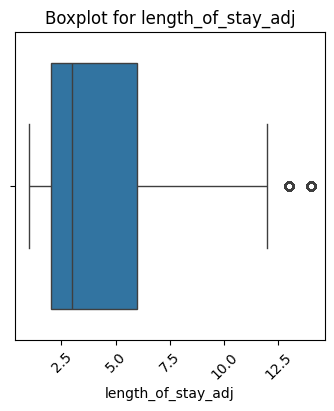

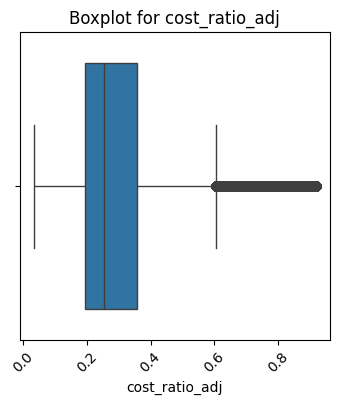

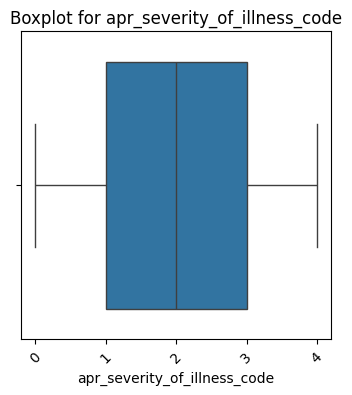

In [8]:
cols = ['length_of_stay_adj', 'cost_ratio_adj', 'apr_severity_of_illness_code']
inpatient_2023['cost_ratio_adj'] = np.log1p(inpatient_2023['cost_ratio_adj']) #Moderate Skewness

#Plotting columns to view distribution regarding chosen response data
for col in cols:
    plt.figure(figsize  (6,4))
    sns.boxplot(x = inpatient_2023[col])
    plt.title(f'Boxplot for {col}')
    plt.xticks(rotation = 45)
    plt.show()


Text(0, 0.5, 'Frequency')

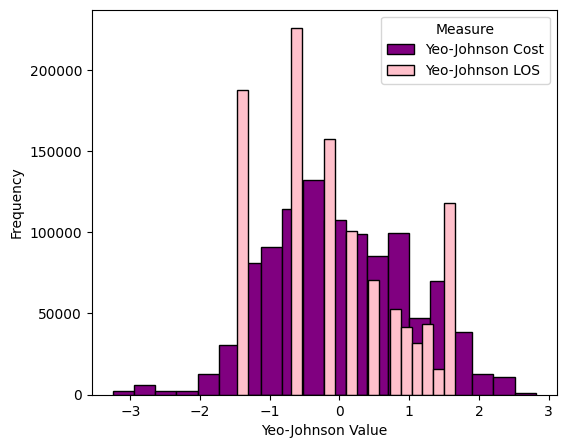

In [9]:
from sklearn.preprocessing import PowerTransformer
fig1, ax1 = plt.subplots(figsize = (6, 5))
#Using Yeo Johnson transformation for optimal transformation parameter
pt1 = PowerTransformer(method = 'yeo-johnson')
inpatient_2023['cost_ratio_yj'] = pt1.fit_transform(inpatient_2023[['cost_ratio']])

#Data appears approximately normal

pt2 = PowerTransformer(method = 'yeo-johnson')
inpatient_2023['length_of_stay_adjusted'] = pt2.fit_transform(inpatient_2023[['length_of_stay_adj']])

ax1.hist(inpatient_2023['cost_ratio_yj'], bins = 20, edgecolor = 'black', label = 'Yeo-Johnson Cost', color = 'purple')
ax1.hist(inpatient_2023['length_of_stay_adjusted'], bins = 20, edgecolor = 'black', label = 'Yeo-Johnson LOS', color = 'pink')

ax1.legend(title = 'Measure')
ax1.set_xlabel('Yeo-Johnson Value')
ax1.set_ylabel('Frequency')

#Despite investigating additional methods of normalization, length of stay cannot be normalized
#This is attributed to it's discrete counts and large right skew

# Merging Data


In [10]:
#Merging the other tables into patient facility 
merge_data = pd.merge(facility_info, inpatient_2023, on = 'Facility_ID', how = 'right')
merge_data.dropna(subset = ['facility_name'], inplace = True)
merged_data = pd.merge(merge_data, insured_county, on = 'county', how = 'left')
merged_data = pd.merge(merged_data, population_data, on = 'county', how = 'left')

# EDA Analysis

In [11]:
#Hospital_info is the main file used during analysis
hospital_info = merged_data.copy()
admit_counts = hospital_info.groupby('county').size().reset_index(name = 'admittance_count')
hospital_info = pd.merge(hospital_info, admit_counts, on = 'county', how = 'left')
hospital_info['visit_rate_county_per_1000'] = (hospital_info['admittance_count'] / hospital_info['population']) * 1000

In [12]:
def cost_plot(admission_type, diagnosis, cost_range):
    cost_df = hospital_info.copy()

    if admission_type != 'All':
        cost_df = cost_df[cost_df['type_of_admission'] == admission_type]

    cost_df = cost_df[cost_df['ccsr_diagnosis_description'] == diagnosis]
    cost_df = cost_df[(cost_df['length_of_stay'] >= cost_range[0]) & (cost_df['length_of_stay'] <= cost_range[1])]

    #Plotting distribution of total cost
    fig, ax1 = plt.subplots(figsize = (5,4))
    ax1.hist(np.log(cost_df['total_costs']), bins = 100, color = 'violet')
    ax1.set_xlabel('Total Cost')
    ax1.set_ylabel('Count')
    plt.show()

In [13]:
#Interative plot displaying average cost per year, diagnosis and region
#Data transformed to appear normally distributed for regression
%matplotlib widget

choice_list = hospital_info['ccsr_diagnosis_description'].unique()
type_widget = widgets.Dropdown(options = ['All', 'Emergency', 'Elective', 'Urgent', 'Newborn', 'Trauma'], value = 'All', description = 'Type', disabled = False)
diagnosis_widget = widgets.Dropdown(options = choice_list, value = 'Septicemia', description = 'Diagnosis:', disabled = False)
cost_widget = widgets.FloatRangeSlider(value = [1,31], min = 1, max = 15, step = 1, description = 'Week:', orientation = 'horizontal', readout = True)

ui = widgets.VBox([type_widget, diagnosis_widget, cost_widget])
output = widgets.interactive_output(cost_plot, {'admission_type': type_widget, 'diagnosis': diagnosis_widget, 'cost_range': cost_widget})
display(ui, output)

Output()

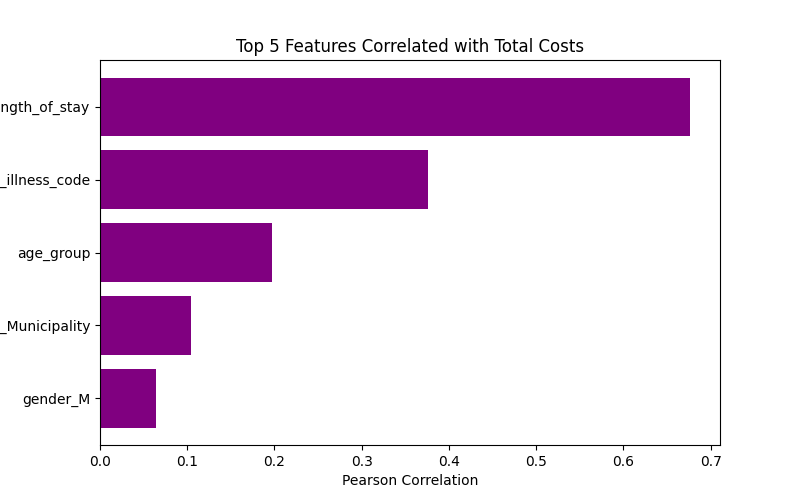

In [14]:
#Which feeatures are critical in predicting cost/payment for each patient?
feature_select = hospital_info[['total_costs', 'length_of_stay', 'ownership_type', 'gender', 'race', 'type_of_admission', 
                                'apr_severity_of_illness_code', 'age_group']].copy()

#Keeping data within the 99 quantile to account for major outliers
cost_99 = feature_select['total_costs'].quantile(0.99)
feature_select = feature_select[feature_select['total_costs'] <= cost_99]

#Mapping and encoding
age_map = {'0 to 17': 0, '18 to 29': 1, '30 to 49': 2,  '50 to 69': 3, '70 or Older': 4}
feature_select['age_group'] = feature_select['age_group'].map(age_map)
encoded_df = pd.get_dummies(feature_select,columns = ['ownership_type', 'gender', 'race', 'type_of_admission'], drop_first = True)
encoded_df = encoded_df[(encoded_df['total_costs'] > 0) & (encoded_df['length_of_stay'] > 0)]
corr_features = encoded_df.corr(method = 'pearson')
corr_features[['total_costs']].sort_values(by = 'total_costs', ascending = False)

#Plotting the figure
plt.figure(figsize = (8, 5))
top_5 = (corr_features[['total_costs']].drop('total_costs').sort_values(by = 'total_costs', ascending = False).head(5))
plt.barh(top_5.index, top_5['total_costs'], color = 'purple')
plt.xlabel('Pearson Correlation')
plt.title('Top 5 Features Correlated with Total Costs')
plt.gca().invert_yaxis() 


Text(0, 0.5, 'Admittance Count')

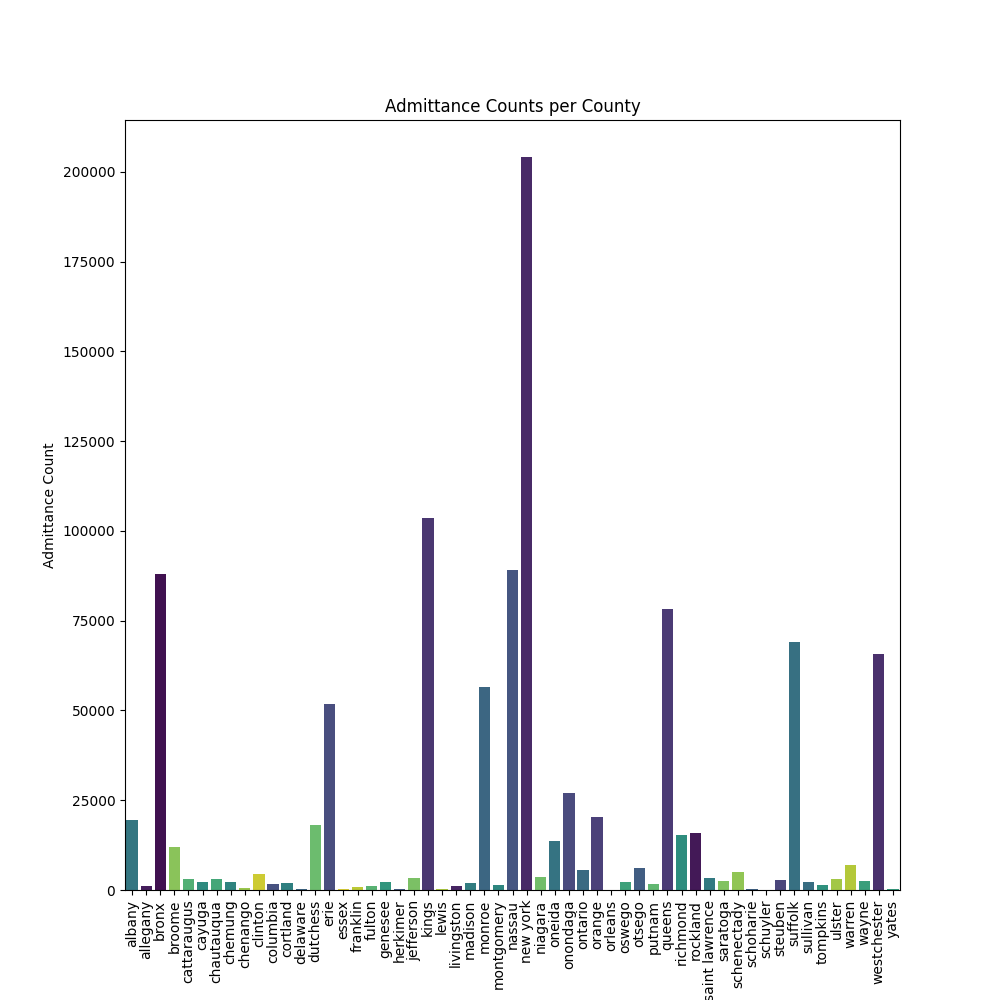

In [15]:
#Distribution of Hospital Occurences Per County 
plt.figure(figsize = (10,10))
sns.countplot(x = 'county', data = hospital_info, hue = 'county', palette = 'viridis', order = sorted(hospital_info['county'].unique()))
plt.xticks(rotation = 90)
plt.title('Admittance Counts per County')
plt.xlabel('County Name')
plt.ylabel('Admittance Count')

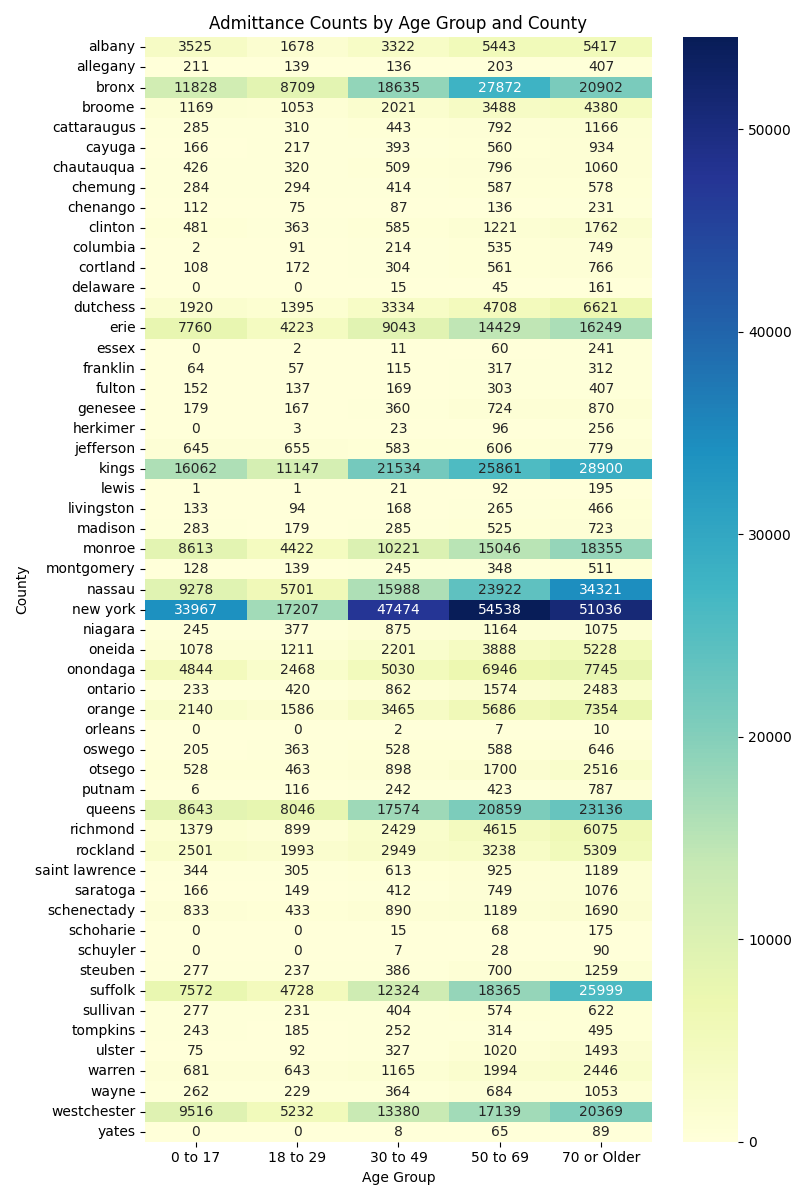

In [16]:
#What about county population demographics, why does New York have the highest per person despite standardizing visits?
hospital_info['age_group'].nunique()
age_lim = (hospital_info.groupby(['county', 'age_group']).size().reset_index(name = 'count'))
pivot = age_lim.pivot(index = 'county', columns = 'age_group', values = 'count').fillna(0)

plt.figure(figsize = (8, 12))
sns.heatmap(pivot, cmap = 'YlGnBu', annot = True, fmt = '.0f')
plt.title('Admittance Counts by Age Group and County')
plt.xlabel('Age Group')
plt.ylabel('County')
plt.tight_layout()
plt.show()

#Larger proportions of people appear in the older demographics

C:\Users\jackm\AppData\Local\Temp\ipykernel_10516\2546959978.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = 'county', y = 'visit_rate_county_per_1000', data=hospital_info, palette = 'plasma', order = sorted(hospital_info['county'].unique()))


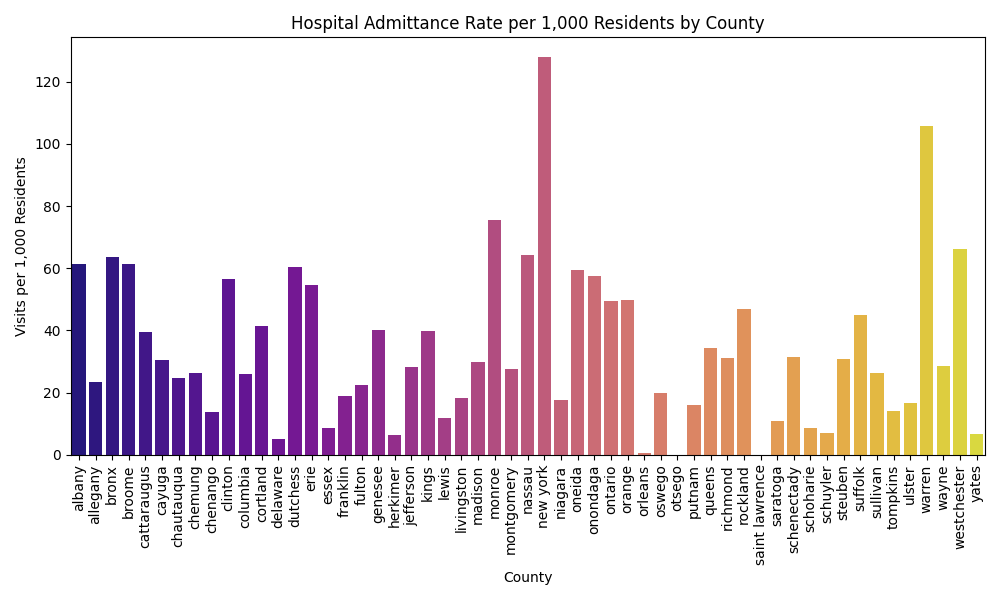

In [17]:
#Tracking visits per 1000 people each county 
plt.figure(figsize = (10, 6))
sns.barplot(x = 'county', y = 'visit_rate_county_per_1000', data = hospital_info, palette = 'plasma', order = sorted(hospital_info['county'].unique()))
plt.xticks(rotation = 90)
plt.title('Hospital Admittance Rate per 1,000 Residents by County')
plt.xlabel('County')
plt.ylabel('Visits per 1,000 Residents')
plt.tight_layout()
plt.show()

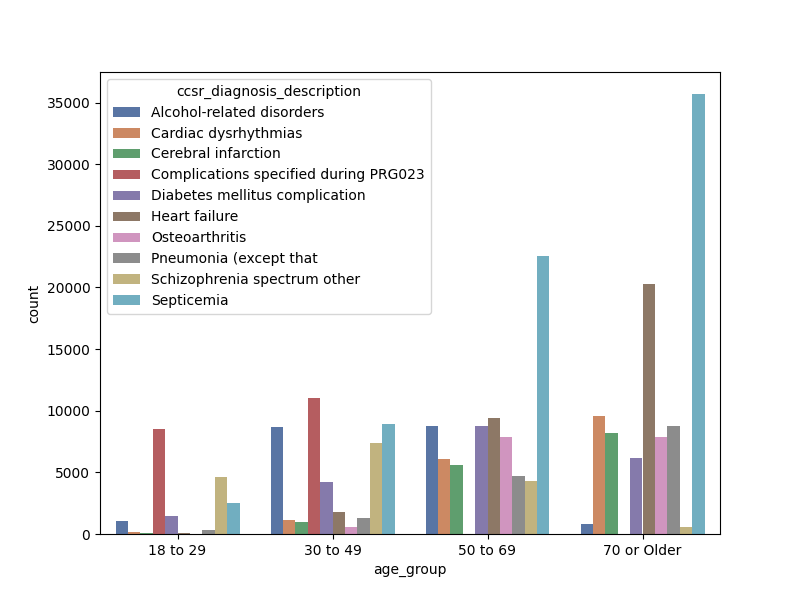

In [18]:
#Comparing age and reason for admittance
age_sick = hospital_info[hospital_info['age_group'] != '0 to 17'].groupby(['age_group', 'ccsr_diagnosis_description']).size().reset_index(name = 'count')
age_sick_10 = age_sick.groupby('ccsr_diagnosis_description')['count'].sum().nlargest(10).index
age_sick_top = age_sick[age_sick['ccsr_diagnosis_description'].isin(age_sick_10)]
plt.figure(figsize = (8,6))
sns.barplot(data = age_sick_top, x = 'age_group', y = 'count', hue = 'ccsr_diagnosis_description', palette = 'deep')
plt.show()

C:\Users\jackm\AppData\Local\Temp\ipykernel_10516\322590254.py:13: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:blue'` for the same effect.

  sns.stripplot(x = 'county', y = 'median_costs', data = median_comb, hue = 'source', jitter = True, color = 'blue')


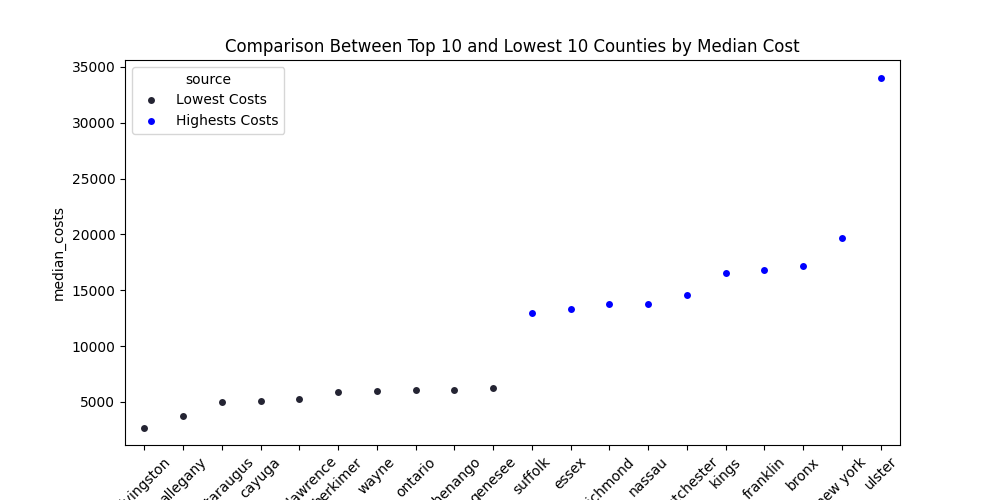

C:\Users\jackm\AppData\Local\Temp\ipykernel_10516\322590254.py:19: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:green'` for the same effect.

  sns.stripplot(x = 'county', y = 'percent_red', data = median_comb, hue = 'source', jitter = True, color = 'green')


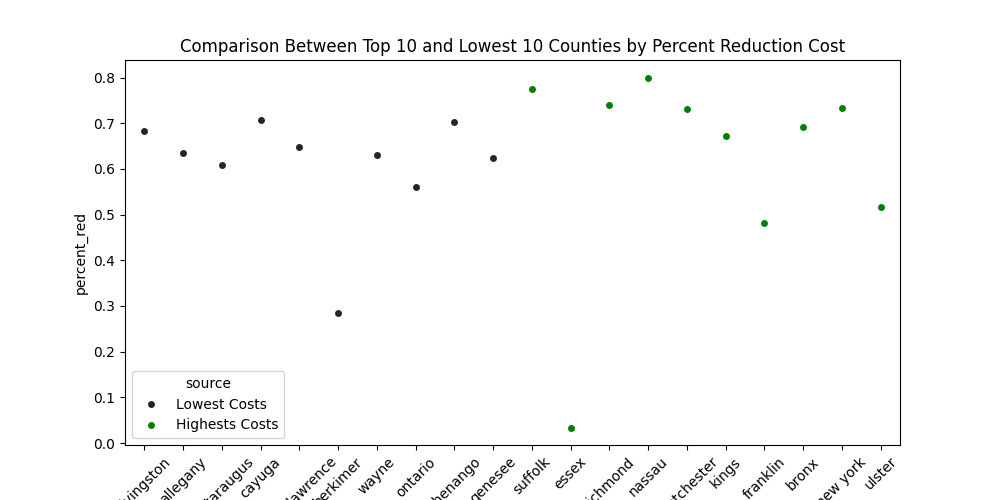

In [19]:
#How much has median cost and percent_reduction differed across top 10 counties and bottom 10 counties
#What are the highest cost visits?
median_list = (
    hospital_info.groupby('county', as_index = False)
    .agg(median_costs = ('total_costs', 'median'), count = ('total_costs', 'size'), percent_red = ('percent_reduction', 'median'))
    .sort_values('median_costs', ascending = True)).set_index('county')

median_list_top = median_list.head(10)
median_list_bottom = median_list.tail(10)
median_comb = pd.concat([median_list_top.assign(source = 'Lowest Costs'), median_list_bottom.assign(source = 'Highests Costs')])

plt.figure(figsize = (10,5))
sns.stripplot(x = 'county', y = 'median_costs', data = median_comb, hue = 'source', jitter = True, color = 'blue')
plt.xticks(rotation = 45)
plt.title('Comparison Between Top 10 and Lowest 10 Counties by Median Cost')
plt.show()

plt.figure(figsize = (10,5))
sns.stripplot(x = 'county', y = 'percent_red', data = median_comb, hue = 'source', jitter = True, color = 'green')
plt.xticks(rotation = 45)
plt.title('Comparison Between Top 10 and Lowest 10 Counties by Percent Reduction Cost')
plt.show()
#During modeling, perform nonparametric difference testing

## High Cost Patient Optimization

1. Which patients drive the majority of hospital costs/Which diagnosis create the greatest bed days?
2. How concentrated are the hospital costs?
3. Are complications affecting the overall costs and to what extent
4. What LOS threshold do the costs increase sharply?

In [61]:
#Cost per LOS day
hospital_info['cost_per_los'] = hospital_info['total_costs'] / hospital_info['length_of_stay']

In [20]:
#A seperating emergency and non emergency instances
emergency_yes = hospital_info[hospital_info['emergency_department_indicator'] == 1]
condition_costs_em = emergency_yes.groupby('ccsr_diagnosis_description', as_index = False)[['total_charges', 'total_costs', 'length_of_stay']].sum().sort_values('total_charges', ascending = False).reset_index(drop = True)
condition_costs_em['percent_reduction'] = (condition_costs_em['total_charges'] - condition_costs_em['total_costs']) / (condition_costs_em['total_charges'])
condition_costs_all = condition_costs_em['total_charges'].sum()

condition_costs_em['percent_total_charge_all'] = (condition_costs_em['total_charges'] / condition_costs_all) * 100
condition_costs_em.head(10)

#The top 10 show that sepsis occurences account for the most LOS and total_cost
#As shown from the EDA, most sepsis occurences are from the older population

,ccsr_diagnosis_description,total_charges,total_costs,length_of_stay,percent_reduction,percent_total_charge_all
0,Septicemia,8.810911e+09,2.663784e+09,619796,0.697672,15.818501
1,Heart failure,2.512851e+09,7.624032e+08,192132,0.696598,4.511399
2,Diabetes mellitus complication,1.560133e+09,4.891777e+08,120906,0.686451,2.800956
3,Cerebral infarction,1.533205e+09,4.390145e+08,97129,0.713662,2.752610
4,Schizophrenia spectrum other,1.221275e+09,5.390942e+08,233584,0.558581,2.192592
5,Acute myocardial infarction,1.178489e+09,3.196574e+08,48224,0.728757,2.115779
6,Pneumonia (except that,1.026386e+09,3.166852e+08,85682,0.691456,1.842703
7,Acute unspecified renal,9.275454e+08,2.711492e+08,78346,0.707670,1.665251
8,Respiratory failure; insufficiency;,8.944643e+08,2.929949e+08,68280,0.672435,1.605860
9,Cardiac dysrhythmias,8.678679e+08,2.479822e+08,50108,0.714263,1.558110


In [21]:
#Non emergency dataset
emergency_no = hospital_info[hospital_info['emergency_department_indicator'] == 0]
condition_costs_op = emergency_no.groupby('ccsr_diagnosis_description', as_index = False)[['total_charges', 'total_costs', 'length_of_stay']].sum().sort_values('total_charges', ascending = False).reset_index(drop = True)
condition_costs_op['percent_reduction'] = (condition_costs_op['total_charges'] - condition_costs_op['total_costs']) / (condition_costs_op['total_charges'])
condition_costs_all = condition_costs_op['total_charges'].sum()

condition_costs_op['percent_total_charge_all'] = (condition_costs_op['total_charges'] / condition_costs_all) * 100
condition_costs_op['charge_per_day'] = condition_costs_op['total_charges'] / condition_costs_op['length_of_stay']
condition_costs_op.head(10)

#Liveborns account for the majority of length of stays and total costs for non emergency visits 

,ccsr_diagnosis_description,total_charges,total_costs,length_of_stay,percent_reduction,percent_total_charge_all,charge_per_day
0,Liveborn,3.763162e+09,9.740932e+08,326324,0.741150,12.107319,11531.979702
1,Osteoarthritis,1.538819e+09,4.538123e+08,35670,0.705091,4.950882,43140.42337
2,Spondylopathies/spondyloarthropathy,1.481676e+09,4.284660e+08,35145,0.710823,4.767034,42158.933006
3,Nonrheumatic unspecified valve,1.084386e+09,2.992735e+08,17794,0.724016,3.488822,60941.086901
4,Coronary atherosclerosis other,9.525326e+08,2.615027e+08,28102,0.725466,3.064608,33895.546342
5,Cardiac dysrhythmias,6.619277e+08,1.738600e+08,15325,0.737343,2.129637,43192.670281
6,Septicemia,6.536706e+08,2.061324e+08,44471,0.684654,2.103071,14698.805709
7,Obesity,5.880346e+08,1.877362e+08,15569,0.680740,1.891899,37769.58376
8,Complications specified during PRG023,5.416292e+08,1.924770e+08,42479,0.644633,1.742598,12750.517063
9,Benign neoplasms,5.277664e+08,1.564106e+08,17602,0.703637,1.697997,29983.322293


In [22]:
#Running Lorenz Curve and gini value for assessing hospital costs among patients 
#Help with setup credited to https://zhiyzuo.github.io/Plot-Lorenz/, appropriate gini formula verified

def gini_lorenz_function(indicator):

    plt.close('all')

    if indicator == 'Emergency':
        X_val = np.sort(emergency_no['total_charges'].values)
    else:
        X_val = np.sort(emergency_yes['total_charges'].values)
        
        
    n = X_val.size
    coef_ = 2. / n
    const_ = (n + 1.) / n
    weighted_sum = sum([(i + 1) * yi for i, yi in enumerate(X_val)])

    lorenz_val = X_val.cumsum() / X_val.sum()
    lorenz_val = np.insert(lorenz_val, 0, 0)
    fig, ax = plt.subplots(figsize = [6,6])
    ax.scatter(np.arange(lorenz_val.size) / (lorenz_val.size - 1), lorenz_val, marker = 'x', color = 'darkred', s = 50)
    ax.plot([0,1], [0,1], color = 'k')
    ax.set_xlabel('Cumulative Patients')
    ax.set_ylabel('Cumulative Total Costs')
    ax.set_title(f'Lorenz Curve for {indicator}')
    plt.show()

    print(f'Gini is {coef_ * weighted_sum / (X_val.sum()) - const_}')
#There is a strong concentration of patients which account for a majority of total charges (before insurance)
    

In [23]:
#Interactive widgets for determining lorenz for different 
lorenz_widget = widgets.Dropdown(options = ['Emergency', 'No Emergency'], value = 'Emergency', description = 'Type', disabled = False)
ui2 = widgets.VBox([lorenz_widget])
output_info = widgets.interactive_output(gini_lorenz_function, {'indicator': lorenz_widget})
display(ui2, output_info)

#Non Emergency occurences have a very strong concentration 

Output()

                            OLS Regression Results                            
Dep. Variable:            log_charges   R-squared:                       0.188
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                 5.973e+04
Date:                Tue, 16 Dec 2025   Prob (F-statistic):               0.00
Time:                        13:25:26   Log-Likelihood:            -1.4277e+06
No. Observations:             1031185   AIC:                         2.855e+06
Df Residuals:                 1031180   BIC:                         2.856e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


C:\Users\jackm\AppData\Roaming\Python\Python310\site-packages\ipympl\backend_nbagg.py:342: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.figure.savefig(buf, format='png', dpi='figure')


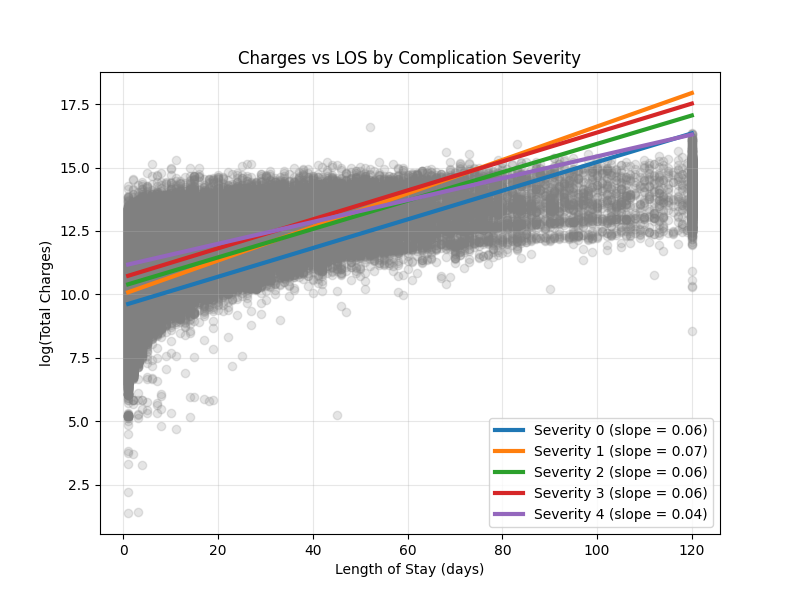

In [24]:
## Question 3 - Complications influence on total costs and LOS

#The severity of illness code 0-4 can be used to measure complication with 0 with the least complications and 4 as the most
hospital_info.groupby('apr_severity_of_illness_code')[['total_charges', 'length_of_stay']].agg(['mean', 'median', 'count'])
#From the table, there appears to be a positive linear trend between severity and costs/LOS

severity_info = hospital_info.copy()
severity_info['log_charges'] = np.log(severity_info['total_charges'])
severity_info['apr_severity_of_illness_code'] = (severity_info['apr_severity_of_illness_code'].astype(int))
print(smf.ols('log_charges ~ C(apr_severity_of_illness_code)', data = severity_info).fit().summary())

severity_colors = {0: 'tab:blue', 1: 'tab:green', 2: 'tab:orange', 3: 'tab:red', 4: 'tab:purple'}

fig, ax = plt.subplots(figsize = (8, 6))
for severity in sorted(severity_info['apr_severity_of_illness_code'].unique()):
    sev_data = severity_info[severity_info['apr_severity_of_illness_code'] == severity]
    X = sev_data[['length_of_stay']].values
    y = sev_data['log_charges'].values
    model_linear = LinearRegression()
    model_linear.fit(X, y)
    x_grid = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    y_prediction = model_linear.predict(x_grid)
    
    ax.scatter(X, y, color = 'gray', alpha = 0.2)
    ax.plot(x_grid, y_prediction, linewidth = 3, label = f'Severity {severity} (slope = {model_linear.coef_[0]:.2f})')

ax.set_xlabel('Length of Stay (days)')
ax.set_ylabel('log(Total Charges)')
ax.set_title('Charges vs LOS by Complication Severity')
ax.legend()
ax.grid(alpha = 0.3)

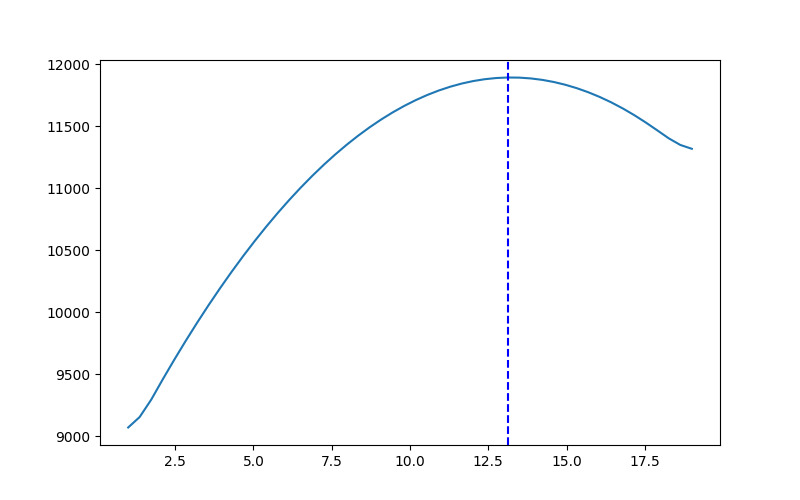

C:\Users\jackm\AppData\Local\Temp\ipykernel_10516\1726871987.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_summary = threshold_2.groupby('bin').agg(los_mean = ('length_of_stay','mean'), logchg_mean = ('log_charges','mean'), n = ('log_charges','size')).dropna()


,los_mean,logchg_mean,n,approx_dy_dx
bin,,,,
"(0.0, 2.0]",1.546864,10.103735,406412,0.264705
"(2.0, 4.0]",3.390222,10.591681,255237,0.235166
"(4.0, 6.0]",5.428325,11.004408,121877,0.169758
"(6.0, 8.0]",7.431872,11.280028,72591,0.118447
"(8.0, 10.0]",9.444989,11.479803,42846,0.086826
"(10.0, 12.0]",11.460251,11.629741,29447,0.061510
"(12.0, 14.0]",13.482743,11.727979,23642,0.067223
"(14.0, 16.0]",15.441178,11.895000,15717,0.073233
"(16.0, 18.0]",17.460684,12.017802,11077,0.047238


In [25]:
#Question 4 - What LOS threshold so costs increase the greatest?
#We can calculate the reduction of spending that could be obtained if given days were reduced to the threshold
#We can use a GAM model, which is a continous function, to graph and identify the greatest negative derivative
#Account for severity of condition

threshold_df = hospital_info.copy()
threshold_df = threshold_df[threshold_df['total_charges'] < threshold_df['total_charges'].nlargest(10).min()]
X = threshold_df[['length_of_stay']].values
y = threshold_df['total_charges'].values

gam_model = LinearGAM(s(0, n_splines = 10)).fit(X, y)
x_value = np.linspace(1, np.percentile(X, 95), 50)
x_reframe = x_value.reshape(-1,1)
y_pred = gam_model.predict(x_reframe)

derivative_val = np.gradient(y_pred, x_value)
smooth_val = uniform_filter1d(derivative_val, size = 3)
threshold_idx = np.argmax(smooth_val)
threshold_info = x_value[threshold_idx]

plt.figure(figsize = (8,5))
plt.plot(x_value, smooth_val)
plt.axvline(threshold_info, linestyle = '--', color = 'blue')
plt.show()

threshold_2 = hospital_info.copy()
threshold_2 = threshold_2[(threshold_2['total_charges'] > 0) & (threshold_2['length_of_stay'] > 0)]
threshold_2['log_charges'] = np.log(threshold_2['total_charges'])

# choosing bins
bins = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, np.inf]
threshold_2['bin'] = pd.cut(threshold_2['length_of_stay'], bins = bins)

# average predicted curve: mean log charges by bin
bin_summary = threshold_2.groupby('bin').agg(los_mean = ('length_of_stay','mean'), logchg_mean = ('log_charges','mean'), n = ('log_charges','size')).dropna()

# "derivative" between bins = change in mean log charges / change in mean LOS
bin_summary['approx_dy_dx'] = np.gradient(bin_summary['logchg_mean'].values,bin_summary['los_mean'].values)
bin_summary

## Payment Forecasting and Resource Management

1. How does patient payment information correlate with cost, LOS, and hospital finances
2. Which feeatures are critical in predicting cost/payment for each patient?
3. Can resource allocation for each individual patient be predicted?

In [32]:
#Function for GAM
#Filters by admission type and diagnosis
#Removes the biggest outlier points, chosen due to the large 1M+ rows of the table

def payment_plot(admission_type, diagnosis):
    payment_df = hospital_info.copy()

    if admission_type != 'All':
        payment_df = payment_df[payment_df['type_of_admission'] == admission_type]

    payment_df = payment_df[payment_df['ccsr_diagnosis_description'] == diagnosis]

    colors = {'Medicaid': 'tab:green','Medicare': 'tab:orange','Private Health Insurance': 'tab:red'}
    payment = ['Medicaid', 'Medicare', 'Private Health Insurance']

    fig, ax = plt.subplots(figsize = (10,6))
    text_place = 0.99

    for pay in payment:
        payment_data = payment_df[payment_df['payment_typology_1'] == pay]
        payment_data = payment_data[payment_data['length_of_stay'] <= payment_data['length_of_stay'].nlargest(10).iloc[-1]]
        y = np.log(payment_data['total_costs'].values)
        X = payment_data[['length_of_stay']].values
    
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)

        gam_model = LinearGAM(s(0, n_splines=10)).fit(X_train, y_train)
        r2 = gam_model.score(X_test, y_test)
        edf = gam_model.statistics_['edof']

        ax.scatter(X_test, y_test, alpha = 0.3, color = colors[pay], label = f"{pay}")
        x_slope = np.linspace(X.min(), X.max(), 31).reshape(-1,1)
        y_predict = gam_model.predict(x_slope)
        
        equation_line = f"{pay}: GAM smooth (EDF ≈ {edf:.1f})"
        ax.plot(x_slope, y_predict, color = colors[pay], linewidth = 3)
        ax.text(0.01, text_place, equation_line, transform = ax.transAxes, color = colors[pay], fontsize = 8, verticalalignment = 'top')

        text_place -= 0.03

        ax.set_xlabel("Length of Stay (days)")
        ax.set_ylabel("log(Total Cost)")
        ax.set_title(f"Cost vs LOS by Payment Type: {diagnosis}")
        ax.legend()
        ax.grid(alpha = 0.3)
    


Output()

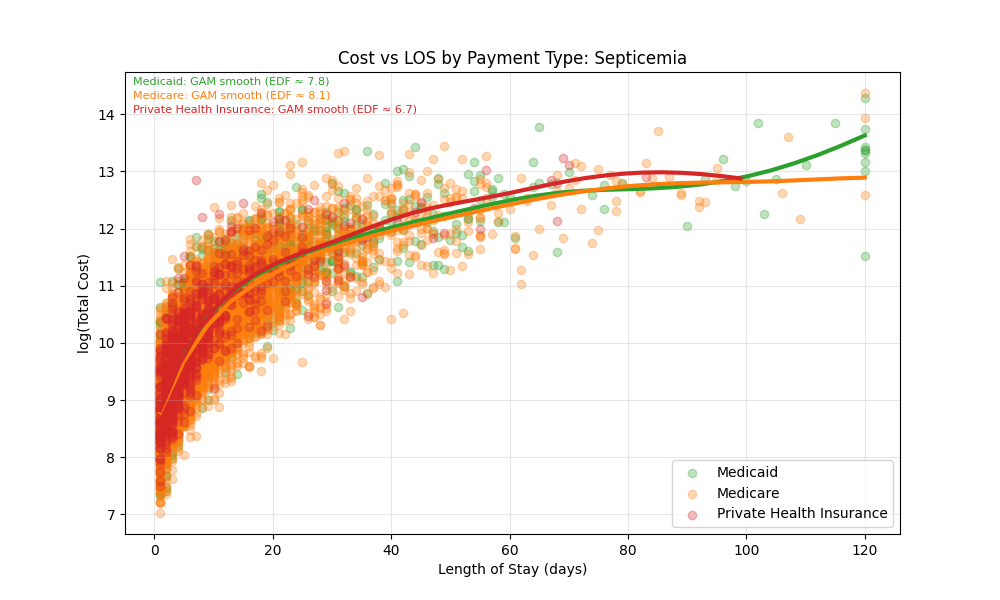

In [39]:
#Question 1: How does patient information correlate with costs?

#plot the data and hue based on payment type
type_widget_2 = widgets.Dropdown(options = ['All', 'Emergency', 'Elective', 'Urgent', 'Newborn', 'Trauma'], value = 'All', description = 'Type', disabled = False)
diagnosis_widge_2 = widgets.Dropdown(options = choice_list, value = 'Septicemia', description = 'Diagnosis:', disabled = False)
#payment_widget = widgets.Dropdown(options = ['Medicaid', 'Medicare', 'Private Health Insurance', 'Self-Pay', 'Blue Cross/Blue Shield', 'Federal/State/Local/VA'],
                                #  value = 'Medicaid', description = 'Payment:', disabled = False)

ui2 = widgets.VBox([type_widget, diagnosis_widget])
output_info = widgets.interactive_output(payment_plot, {'admission_type': type_widget, 'diagnosis': diagnosis_widget})
display(ui2, output_info)

#As shown from the GAM model, the total log cost of after insurance is dependent on the type of admission and diagnosis level
#Medicaid and Medicare generally result in less costs than Private Health Insurance
#More focus was on the distance between predicted lines rather than the lines themselves

In [29]:
#Surival Analysis
#We will implement the Cox Proportional Hazards model to determine how each variable affects the risk of prolonged LOS
#One assumption issue is the data cannot be verified to be proportional hazard
from lifelines import CoxPHFitter, KaplanMeierFitter

cph = CoxPHFitter()
#To balance statistical power with interpretability, primary analyses was performed on a stratified sample while confirming robustness.
survival_encode = (encoded_df.groupby('type_of_admission_Emergency', group_keys = False).apply(lambda x: x.sample(frac = 0.10, random_state = 10)))
survival_encode['event'] = 1
survival_encode = survival_encode.drop(columns = ['total_costs'])
bool_cols = survival_encode.select_dtypes(include = 'bool').columns
survival_encode[bool_cols] = survival_encode[bool_cols].astype(int)

cph.fit(survival_encode, duration_col = 'length_of_stay', event_col = 'event')
cph.print_summary()

#From the model, it's shown that public hospistals generally have longer LOS than private
#Concordance is good at 0.69, predicting the actual LOS days for a given background. 

C:\Users\jackm\AppData\Local\Temp\ipykernel_10516\2280443284.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  survival_encode = (encoded_df.groupby('type_of_admission_Emergency', group_keys = False).apply(lambda x: x.sample(frac = 0.10, random_state = 10)))
C:\Users\jackm\AppData\Roaming\Python\Python310\site-packages\lifelines\utils\__init__.py:1100: ConvergenceWarning: Column(s) ['gender_U'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


<lifelines.CoxPHFitter: fitted with 102088 total observations, 0 right-censored observations>
             duration col = 'length_of_stay'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 102088
number of events observed = 102088
   partial log-likelihood = -1064138.38
         time fit was run = 2025-12-16 18:25:44 UTC

---
                                           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                  
apr_severity_of_illness_code              -0.44      0.65      0.00           -0.45           -0.43                0.64                0.65
age_group                                 -0.04      0.96      0.00           -0.05           -0.04                0.95                0.96
ownership_type_Municipality               -0.86      0.42      0.15           -1.14           -0.57                0.32                0.57
ownership_type_Not for Profit Corporation -0.70      0.50      0.15           -0.99           -0.42                0.37                0.66
ownership_type_Public Benefit Corporation -1.09      0.34      0.15           -1.38           -0.80                0.25                0.45
ownership_type_State                      -0.85      0.43      0.15           -1.14           -0.56                0.32                0.57
gender_M                                  -0.09      0.91      0.01           -0.10           -0.08                0.90                0.92
gender_U                                   0.01      1.01      0.33           -0.64            0.67                0.53                1.95
race_Multi-racial                          0.10      1.10      0.03            0.05            0.15                1.05                1.17
race_Other Race                            0.15      1.17      0.01            0.14            0.17                1.14                1.19
race_White                                 0.13      1.14      0.01            0.11            0.15                1.12                1.16
type_of_admission_Emergency               -0.12      0.89      0.01           -0.13           -0.10                0.88                0.91
type_of_admission_Newborn                  0.19      1.21      0.02            0.16            0.22                1.18                1.25
type_of_admission_Not Available           -0.39      0.68      0.12           -0.61           -0.16                0.54                0.85
type_of_admission_Trauma                  -0.02      0.98      0.05           -0.13            0.08                0.88                1.09
type_of_admission_Urgent                  -0.22      0.80      0.01           -0.25           -0.19                0.78                0.83

                                           cmp to       z      p  -log2(p)
covariate                                                                 
apr_severity_of_illness_code                 0.00 -116.75 <0.005       inf
age_group                                    0.00  -14.23 <0.005    150.16
ownership_type_Municipality                  0.00   -5.85 <0.005     27.64
ownership_type_Not for Profit Corporation    0.00   -4.81 <0.005     19.37
ownership_type_Public Benefit Corporation    0.00   -7.42 <0.005     42.92
ownership_type_State                         0.00   -5.77 <0.005     26.93
gender_M                                     0.00  -14.32 <0.005    152.08
gender_U                                     0.00    0.04   0.97      0.04
race_Multi-racial                            0.00    3.61 <0.005     11.67
race_Other Race                              0.00   16.33 <0.005    196.77
race_White                                   0.00   14.93 <0.005    165.00
type_of_admission_Emergency                  0.00  -13.31 <0.005    131.90
type_of_admission_Newborn                    0.00  

In [37]:
#Plotting the survival analysis
def survival_func(diagnosis):

    feature_select = hospital_info[['length_of_stay', 'ownership_type', 'gender', 'race', 'type_of_admission', 
                                'apr_severity_of_illness_code', 'age_group', 'ccsr_diagnosis_description']].copy()

    age_map = {'0 to 17': 0, '18 to 29': 1, '30 to 49': 2,  '50 to 69': 3, '70 or Older': 4}
    feature_select['age_group'] = feature_select['age_group'].map(age_map)
    feature_select = feature_select[feature_select['ccsr_diagnosis_description'] == diagnosis]
    feature_select['event'] = 1
    survival_encode = pd.get_dummies(feature_select,columns = ['ownership_type', 'gender', 'race', 'type_of_admission'], drop_first=True)
    
    kmf = KaplanMeierFitter()
    fig, ax3 = plt.subplots(figsize = (8, 6))
    for label, group in survival_encode.groupby('type_of_admission_Emergency'):
        kmf.fit(durations = group['length_of_stay'], event_observed = group['event'], label = ('Emergency' if label == 1 else 'Non-Emergency'))
        kmf.plot_survival_function(ax = ax3)
    
    ax3.set_title('Kaplan–Meier Curves for Length of Stay')
    ax3.set_xlabel('Days Since Admission')
    ax3.set_ylabel('Probability of Remaining Hospitalized')
    ax3.set_xlim(0, 31)
    plt.show()

In [38]:
#Question 3: Can resource allocation be predicted?

#We can use survival analysis to predict the probability the patient will remain hospitalized, filtering between Non-Emergency/Emergency and
#plotting for each specified diagnosis. 
#Some plots may appear shorter length than others due to lack of relevant data

#This plot uses the Kaplain-Meier curve, which is non parametric and used to evaluate probabilities than used as regression. 

#Selecting the survival analysis per diagnosis
diagnosis_widget = widgets.Dropdown(options = choice_list, value = 'Septicemia', description = 'Diagnosis:', disabled = False)
ui = widgets.VBox([diagnosis_widget])
output_info = widgets.interactive_output(survival_func, {'diagnosis': diagnosis_widget})
display(ui, output_info)

#Overall, Non-Emergency has a greater chance of longer LOS
#This can be attributed to recovering in rehab from elective procedures
#Non-Emergency accounts for everything else (Urgent, Elective) 

Output()